In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df = pd.read_csv("amazon_reviews.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


# Normalizing Case Folding

In [3]:
df['reviewText'] = df['reviewText'].str.lower()

# Punctuations

In [4]:
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Numbers

In [5]:
df['reviewText'] = df['reviewText'].str.replace('\d', '')

# Stopwords

In [6]:
import nltk
nltk.download('stopwords')

sw = stopwords.words('english')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Rarewords

In [7]:
temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts()

drops = temp_df[temp_df <= 1]

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

# Lemmatization

In [8]:
nltk.download('wordnet')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Text Visualization

In [9]:
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)

,words,tf
27,card,5537.00
14,work,2044.00
7,phone,1909.00
39,gb,1756.00
98,great,1445.00
...,...,...
2723,headline,2.00
2722,sizethe,2.00
2720,everybody,2.00
3690,chkdsk,2.00


# Barplot

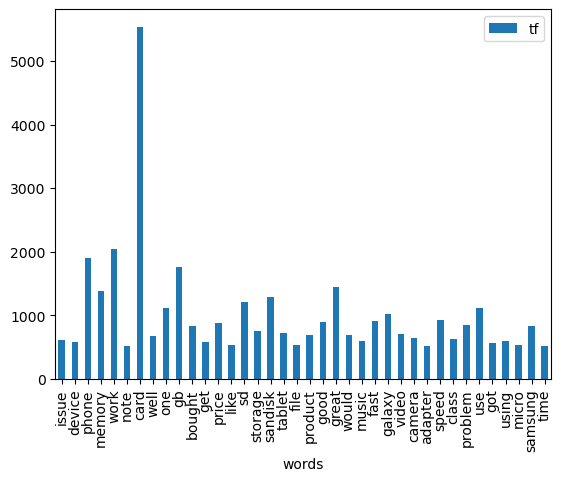

In [10]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

# Wordcloud

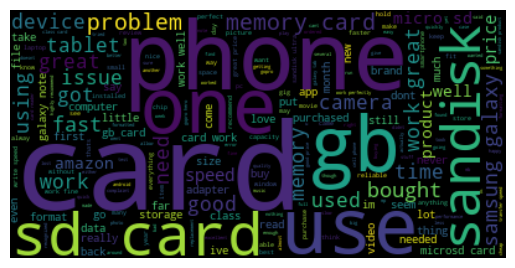

In [11]:
text = " ".join(i for i in df.reviewText)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment Analysis

In [12]:
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

In [13]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [15]:
print(df[['reviewText','polarity_score']])

                                             reviewText  polarity_score
0                                                 issue            0.00
1     purchased device worked advertised never much ...            0.00
2     work expected higher capacity think made bit e...            0.40
3     think worked gb card went south one held prett...            0.65
4     bought retail packaging arrived legit envelope...            0.86
...                                                 ...             ...
4910  bought sandisk gb class use htc inspire month ...            0.08
4911  used capability samsung galaxy note greatly ex...            0.18
4912  great card fast reliable come optional adapter...            0.85
4913         good amount space stuff want fit gopro say            0.69
4914  ive heard bad thing gb micro sd card crapping ...            0.53

[4915 rows x 2 columns]


# Feature Engineering

In [16]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"].value_counts()

pos    3944
neg     971
Name: sentiment_label, dtype: int64

In [17]:
df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   4.09
pos   4.71
Name: overall, dtype: float64

In [18]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

y = df["sentiment_label"]
X = df["reviewText"]

# Count Vectors

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

# TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

# Sentiment Modeling

## Logistic Regression

In [21]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()

0.830111902339776

In [22]:
new_review = pd.Series("this product is great")
new_review = TfidfVectorizer().fit(X).transform(new_review)
log_model.predict(new_review)

array([1])

In [23]:
random_review = pd.Series(df["reviewText"].sample(1).values)
new_review = TfidfVectorizer().fit(X).transform(random_review)

log_model.predict(new_review)

array([0])

## Random Forests

In [24]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8362156663275687

In [25]:
# TF-IDF
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

0.8250254323499492